In [3]:
# Imports and paths — adjust DATA_DIR to your local extraction root
from PIL import Image, ImageFile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
ImageFile.LOAD_TRUNCATED_IMAGES = True

data_folder = r"D:\Python\food-101"
image_folder = os.path.join(data_folder,"images")
meta_folder = os.path.join(data_folder,"meta")


Discovered records: 101000  — files present: 101000


class
apple_pie/1005649.jpg           1
shrimp_and_grits/3773036.jpg    1
shrimp_and_grits/3770174.jpg    1
shrimp_and_grits/3769318.jpg    1
shrimp_and_grits/3762484.jpg    1
shrimp_and_grits/376154.jpg     1
shrimp_and_grits/3752187.jpg    1
shrimp_and_grits/3748011.jpg    1
shrimp_and_grits/3725424.jpg    1
shrimp_and_grits/3723074.jpg    1
shrimp_and_grits/3719231.jpg    1
shrimp_and_grits/3714016.jpg    1
shrimp_and_grits/3712659.jpg    1
shrimp_and_grits/3712305.jpg    1
shrimp_and_grits/3708256.jpg    1
shrimp_and_grits/3707845.jpg    1
shrimp_and_grits/3707105.jpg    1
shrimp_and_grits/3698134.jpg    1
shrimp_and_grits/3686791.jpg    1
shrimp_and_grits/368383.jpg     1
Name: count, dtype: int64

Classes total: 101000
Images total: 101000
Missing files: 0


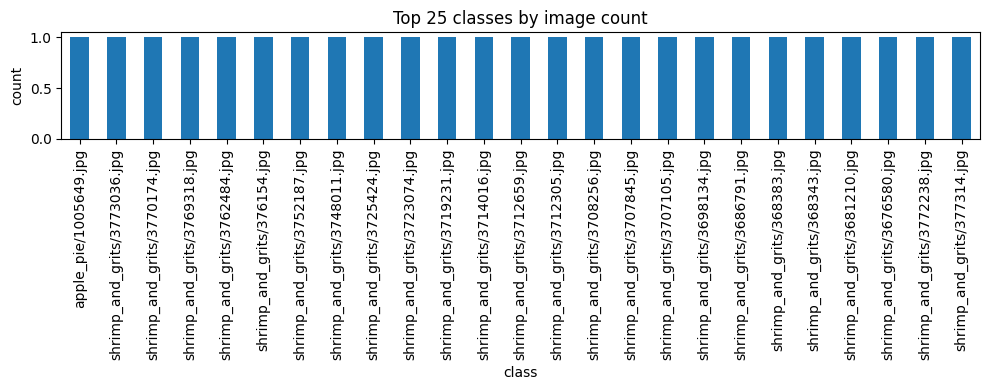

In [4]:
# %% Cell 1 — Build a table of image paths and class names (use meta if available)
records = []
meta_train = os.path.join(meta_folder, "train.txt")
meta_test = os.path.join(meta_folder, "test.txt")
meta_files = [meta_train, meta_test]

if os.path.isdir(meta_folder) and any(os.path.exists(p) for p in meta_files):
    for p in meta_files:
        if not os.path.exists(p):
            continue
        with open(p, "r", encoding="utf-8") as f:
            for line in f:
                rel = line.strip()
                if not rel:
                    continue
                # meta lines are like: "class_name/filename" (without .jpg)
                fname = rel if rel.lower().endswith(".jpg") else rel + ".jpg"
                full = os.path.join(image_folder, fname)
                cls = fname.split(os.sep)[0]
                records.append({"image_path": full, "class": cls})
else:
    # fallback: scan images/<class>/*.jpg
    for cls in sorted(os.listdir(image_folder)):
        cls_dir = os.path.join(image_folder, cls)
        if not os.path.isdir(cls_dir):
            continue
        for fname in os.listdir(cls_dir):
            if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
                continue
            full = os.path.join(cls_dir, fname)
            records.append({"image_path": full, "class": cls})

df = pd.DataFrame(records)
df["exists"] = df["image_path"].apply(os.path.exists)
print(f"Discovered records: {len(df)}  — files present: {df['exists'].sum()}")

# %% Cell 2 — Basic class distribution & counts
class_counts = df["class"].value_counts()
display(class_counts.head(20))            # top 20 classes by image count
print("Classes total:", class_counts.size)
print("Images total:", len(df))
print("Missing files:", len(df) - df["exists"].sum())

# quick bar plot for the top classes
plt.figure(figsize=(10, 4))
class_counts.head(25).plot(kind="bar")
plt.title("Top 25 classes by image count")
plt.xlabel("class")
plt.ylabel("count")
plt.tight_layout()
plt.show()


Total images: 101000
Present and readable: 101000
Unreadable/corrupt or missing: 0 (includes missing files)
Width: min, mean, median, max -> 193 495.79139603960397 512.0 512
Height: 122 475.3721287128713 512.0 512


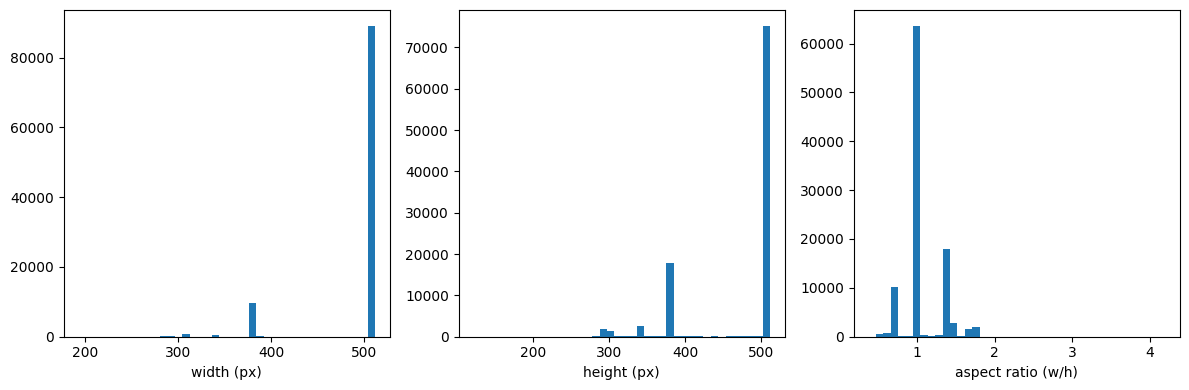

In [6]:
# %% Cell 3 — Probe images: sizes, aspect ratios, corruption check, mean RGB
widths = []
heights = []
aspects = []
mean_r = []
mean_g = []
mean_b = []
is_corrupt = []

# iterate row-wise; keep it simple (may take a few minutes depending on disk/IO)
for _, row in df.iterrows():
    path = row["image_path"]
    if not row["exists"]:
        widths.append(None); heights.append(None); aspects.append(None)
        mean_r.append(None); mean_g.append(None); mean_b.append(None)
        is_corrupt.append(True)
        continue
    try:
        with Image.open(path) as im:
            im = im.convert("RGB")
            w, h = im.size
            arr = np.asarray(im)
            widths.append(w)
            heights.append(h)
            aspects.append(w / h if h != 0 else None)
            # per-image mean per channel
            mean_r.append(float(arr[:, :, 0].mean()))
            mean_g.append(float(arr[:, :, 1].mean()))
            mean_b.append(float(arr[:, :, 2].mean()))
            is_corrupt.append(False)
    except Exception as e:
        widths.append(None); heights.append(None); aspects.append(None)
        mean_r.append(None); mean_g.append(None); mean_b.append(None)
        is_corrupt.append(True)

df["width"] = widths
df["height"] = heights
df["aspect"] = aspects
df["mean_r"] = mean_r
df["mean_g"] = mean_g
df["mean_b"] = mean_b
df["is_corrupt"] = is_corrupt

# summary numbers
total = len(df)
corrupt = df["is_corrupt"].sum()
present = df["exists"].sum()
print(f"Total images: {total}")
print(f"Present and readable: {present - corrupt}")
print(f"Unreadable/corrupt or missing: {corrupt} (includes missing files)")

# %% Cell 4 — Size & aspect statistics
print("Width: min, mean, median, max ->", df["width"].dropna().min(), df["width"].dropna().mean(), df["width"].dropna().median(), df["width"].dropna().max())
print("Height:", df["height"].dropna().min(), df["height"].dropna().mean(), df["height"].dropna().median(), df["height"].dropna().max())

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(df["width"].dropna(), bins=40)
plt.xlabel("width (px)")
plt.subplot(1, 3, 2)
plt.hist(df["height"].dropna(), bins=40)
plt.xlabel("height (px)")
plt.subplot(1, 3, 3)
plt.hist(df["aspect"].dropna(), bins=40)
plt.xlabel("aspect ratio (w/h)")
plt.tight_layout()
plt.show()

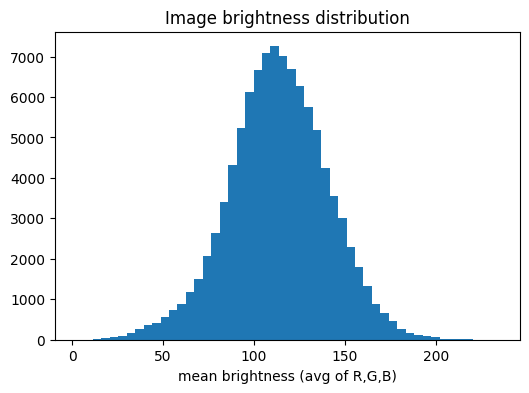

,mean_r,mean_g,mean_b
class,,,
apple_pie/1005649.jpg,118.621119,115.015232,105.471699
shrimp_and_grits/3773036.jpg,120.662987,97.784950,80.292664
shrimp_and_grits/3770174.jpg,199.470318,165.138199,124.265259
shrimp_and_grits/3769318.jpg,132.598232,93.489605,67.126438
shrimp_and_grits/3762484.jpg,121.704388,106.694141,87.895130
shrimp_and_grits/376154.jpg,128.279031,114.173542,84.683026
shrimp_and_grits/3752187.jpg,124.715626,96.355999,73.535507
shrimp_and_grits/3748011.jpg,162.189846,145.395535,129.863627
shrimp_and_grits/3725424.jpg,110.978164,95.536758,81.731118


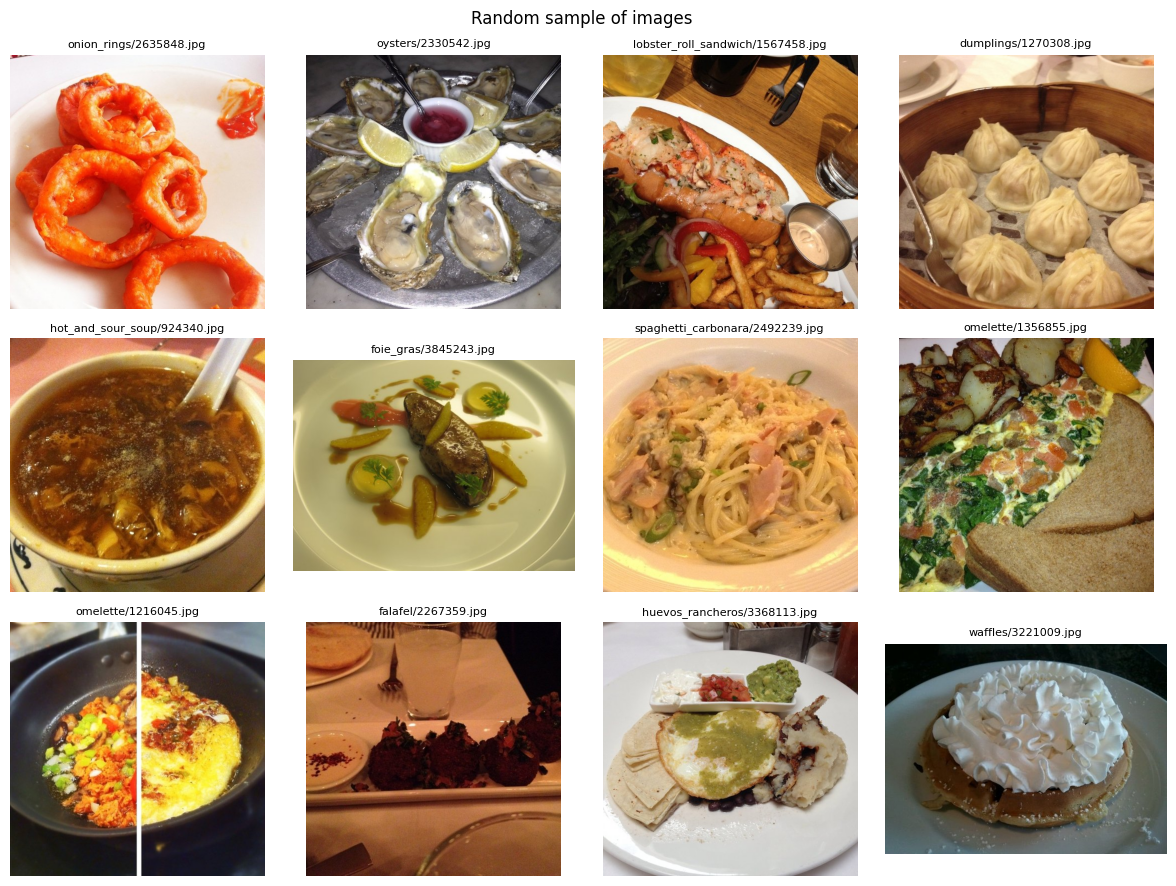

In [7]:
# %% Cell 5 — Mean RGB distribution (global & per-class head)
plt.figure(figsize=(6, 4))
brightness = df[["mean_r", "mean_g", "mean_b"]].mean(axis=1).dropna()
plt.hist(brightness, bins=50)
plt.xlabel("mean brightness (avg of R,G,B)")
plt.title("Image brightness distribution")
plt.show()

# per-class mean color for top classes
per_class_color = df.dropna(subset=["mean_r"]).groupby("class")[["mean_r", "mean_g", "mean_b"]].mean()
display(per_class_color.loc[class_counts.index[:10]])  # show top-10 classes' mean color

# %% Cell 6 — Display example images (grid) — sample from present and readable images
sample_n = 12
sample = df[(~df["is_corrupt"]) & (df["exists"])].sample(sample_n, random_state=42)
ncols = 4
nrows = int(np.ceil(sample_n / ncols))
plt.figure(figsize=(ncols * 3, nrows * 3))
for i, (_, row) in enumerate(sample.iterrows()):
    img = Image.open(row["image_path"]).convert("RGB")
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(row["class"], fontsize=8)
plt.suptitle("Random sample of images")
plt.tight_layout()
plt.show()